In [67]:
!pip install tables
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pickle import dump, load
from sklearn.utils import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import matplotlib.pyplot as plt
from collections import OrderedDict

combined_data = pd.read_hdf("source_files/combined_data_C1.hdf5")

INPUT_COLUMNS = ["start_speed", "spin_rate", "spin_dir", "px", "pz", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["at_bat_score"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)
#Normalization
scaler = StandardScaler().fit(combined_inputs.values)
combined_inputs = scaler.transform(combined_inputs.values)
dump(scaler, open('scripts/scaler.pkl', 'wb'))

# nn_data = pd.concat([combined_inputs, combined_data[OUTPUT_COLUMNS]], axis=1)
# nn_data.to_hdf("../source_files/model_data.hdf5", key="df")

combined_inputs = torch.tensor(combined_inputs, dtype=torch.float32).cuda()
outputs = torch.tensor(combined_data[OUTPUT_COLUMNS].values, dtype=torch.float32).cuda()

del combined_data


In [68]:
class FFNetPytorch(nn.Module):
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, output_size, bias=True)

    self.to(torch.float32)
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.relu(self.layer1(x))
    x = self.layer2(x)

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [72]:

#------------- Train --------------
X_train, X_test, Y_train, Y_test = \
    train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 1

HIDDEN1_SIZE = 64
# HIDDEN2_SIZE = 4

batch_size = 512
max_epochs = 60

print_every = 1
test_every = 1
SAVE_EVERY = 10

LR = 1e-3


SAVE_MODEL = True
LOAD_MODEL = True
SAVE_PATH = "HL1_" + str(HIDDEN1_SIZE)
MODEL_SAVE_PATH = "scripts/batting/models/" + SAVE_PATH + ".pt"
TRAIN_LOSSES_SAVE_PATH = "scripts/batting/trainingloss/" + SAVE_PATH + ".csv"
TEST_LOSSES_SAVE_PATH = "scripts/batting/testloss/" + SAVE_PATH + ".csv"
ACCURACY_SAVE_PATH = "scripts/batting/accuracies/" + SAVE_PATH + ".csv"

CONV_SIZE = 10 #CONVERGENCE_WINDOW_SIZE
CONVERGENCE_THRESHOLD = 0.0001

model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hl1=HIDDEN1_SIZE)
train_losses =[]
test_losses=[]
train_accuracies = []

if LOAD_MODEL:
    try:
      model = torch.load(MODEL_SAVE_PATH)
      train_losses = np.fromfile(TRAIN_LOSSES_SAVE_PATH, sep=',').tolist()
      test_losses = np.fromfile(TEST_LOSSES_SAVE_PATH, sep=',').tolist()
      train_accuracies = np.fromfile(ACCURACY_SAVE_PATH, sep=',').tolist()
    except FileNotFoundError:
      pass
  
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
loss_fn = nn.MSELoss()
#torch.manual_seed(314159)
device = torch.device("cuda")

dataset_train = CustomDataset(X_train, Y_train)
dataset_test = CustomDataset(X_test, Y_test)

model = model.to(device)
model.train()
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)#, num_workers = 4)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)#, num_workers = 4)

accuracies = []
max_epoch = max_epochs + len(train_losses)
train_dif = 0
epoch = len(train_losses)

train_mbatches = X_train.shape[0] // batch_size
test_mbatches = X_test.shape[0] // batch_size

while epoch < max_epoch and (train_dif > CONVERGENCE_THRESHOLD or train_dif == 0):
  batch_losses = []
  batch_accuracies = []
  # for batch_idx, (data, target) in enumerate(train_loader):
  for batch_idx in range(train_mbatches):
    data = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
    target = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
    # print(data.device)
    # data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    prediction = torch.round(output)
    accuracy = torch.sum(prediction == target)/len(target)
    loss.backward()
    optimizer.step()
    batch_losses.append(loss.item())
    batch_accuracies.append(accuracy.item())
  
  #if epoch > 3: scheduler.step()
  test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).item()
  accuracies.append(test_accuracy)
  train_losses.append(torch.mean(torch.Tensor(batch_losses)).item())
  train_dif = (np.max(train_losses[-CONV_SIZE:])-np.min(train_losses[-CONV_SIZE:]))/np.mean(train_losses[-CONV_SIZE:])

  model.eval()
  batch_losses = []

  if epoch % test_every == 0:
    for batch_idx in range(test_mbatches):
      data = X_test[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
      target = Y_test[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
      
      # data, target = data.to(device), target.to(device)
      output = model(data)
      loss = loss_fn(output, target)
      batch_losses.append(loss.item())

    test_losses.append(torch.mean(torch.Tensor(batch_losses)).item())

  if (epoch % SAVE_EVERY == 0) & (epoch != 0):
    print("----- SAVED -----")
    torch.save(model, MODEL_SAVE_PATH)
    np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
    np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
    np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

  if epoch % print_every == 0:
    print('{epoch}/{max_epoch}, Train Loss: {loss:.6f}, Test Loss: {test_loss:.6f}, Accuracy: {accuracy:.4f}%, Difference {diff:.3f}%, lr: {lr}'.format(
                epoch=epoch, max_epoch=max_epoch, loss=train_losses[-1], test_loss=test_losses[-1], \
                accuracy = test_accuracy*100, diff=train_dif*100, lr=scheduler.get_last_lr()[0]))

  epoch += 1

if SAVE_MODEL:
  torch.save(model, MODEL_SAVE_PATH)
  np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
  np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
  np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')


67/127, Train Loss: 3.066151, Test Loss: 3.069974, Accuracy: 15.3064%, Difference 0.045%, lr: 3.3333333333333335e-05
68/127, Train Loss: 3.066027, Test Loss: 3.069959, Accuracy: 15.3185%, Difference 0.047%, lr: 3.3333333333333335e-05
69/127, Train Loss: 3.065991, Test Loss: 3.069958, Accuracy: 15.3248%, Difference 0.047%, lr: 3.3333333333333335e-05
----- SAVED -----
70/127, Train Loss: 3.065970, Test Loss: 3.069959, Accuracy: 15.3259%, Difference 0.047%, lr: 3.3333333333333335e-05
71/127, Train Loss: 3.065955, Test Loss: 3.069959, Accuracy: 15.3285%, Difference 0.046%, lr: 3.3333333333333335e-05
72/127, Train Loss: 3.065943, Test Loss: 3.069960, Accuracy: 15.3290%, Difference 0.046%, lr: 3.3333333333333335e-05
73/127, Train Loss: 3.065933, Test Loss: 3.069961, Accuracy: 15.3283%, Difference 0.045%, lr: 3.3333333333333335e-05
74/127, Train Loss: 3.065924, Test Loss: 3.069962, Accuracy: 15.3279%, Difference 0.045%, lr: 3.3333333333333335e-05
75/127, Train Loss: 3.065915, Test Loss: 3.069

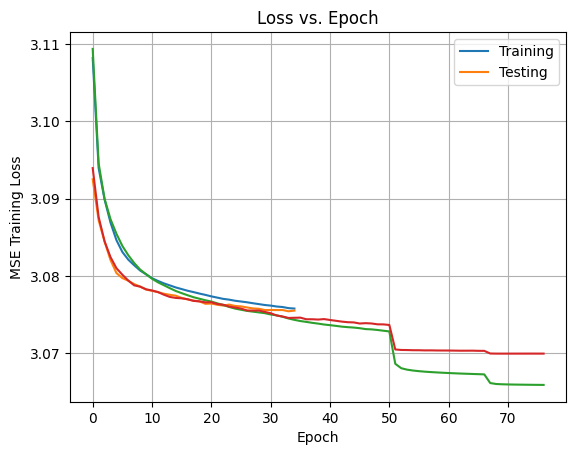

In [73]:
import matplotlib.pyplot as plt


#training_4_1 = np.fromfile("trainingloss/HL2_4_1.csv", sep=',').tolist()

training_128_1 = np.fromfile("scripts/batting/trainingloss/HL1_64.csv", sep=',').tolist()
testing_128_1 = np.fromfile("scripts/batting/testloss/HL1_64.csv", sep=',').tolist()

training_64 = np.fromfile("scripts/batting/trainingloss/HL1_64f16.csv", sep=',').tolist()
testing_64 = np.fromfile("scripts/batting/testloss/HL1_64f16.csv", sep=',').tolist()

plt.figure()
plt.plot(training_64)
plt.plot(testing_64)
plt.plot(training_128_1)
plt.plot(testing_128_1)
# for i in range(0,7):
#     plt.plot(np.fromfile("batting/trainingloss/HL2_" + str(2**i) + "_1.csv", sep=',').tolist())
plt.grid()
# plt.ylim(3.08, 3.2)
plt.xlabel("Epoch")
plt.ylabel("MSE Training Loss")
plt.legend(["Training", "Testing"])
# plt.legend(["HL Size 1", "HL Size 2", "HL Size 4", "HL Size 8", "HL Size 16", "HL Size 32", "HL Size 64"])
plt.title("Loss vs. Epoch")

plt.show()

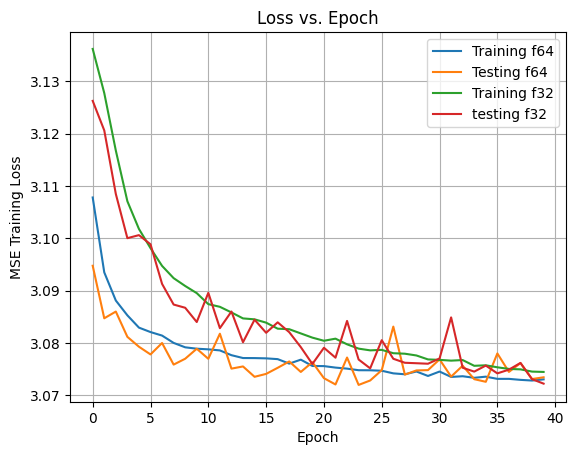

In [21]:
import matplotlib.pyplot as plt
training_64 = np.fromfile("batting/trainingloss/HL1_6464.csv", sep=',').tolist()
testing_64 = np.fromfile("batting/testloss/HL1_6464.csv", sep=',').tolist()

training_64f32 = np.fromfile("batting/trainingloss/HL1_64f32.csv", sep=',').tolist()
testing_64f32 = np.fromfile("batting/testloss/HL1_64f32.csv", sep=',').tolist()

plt.figure()
plt.plot(training_64)
plt.plot(testing_64)
plt.plot(training_64f32)
plt.plot(testing_64f32)
plt.legend(["Training f64", "Testing f64", "Training f32", "testing f32"])

plt.grid()

plt.xlabel("Epoch")
plt.ylabel("MSE Training Loss")
# plt.legend(["HL Size 1", "HL Size 2", "HL Size 4", "HL Size 8", "HL Size 16", "HL Size 32", "HL Size 64"])
plt.title("Loss vs. Epoch")

plt.show()

<a list of 17 text.Text objects>

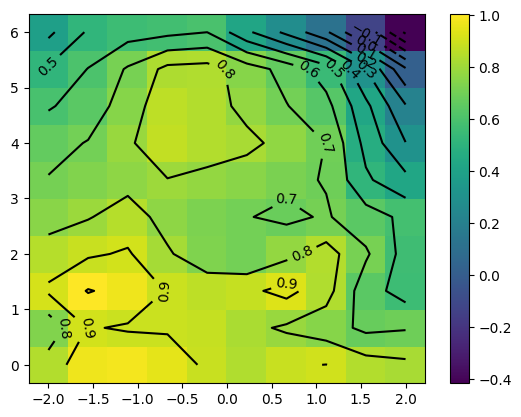

In [85]:
# %%prun

context = {
    "b_score": 0,
    "p_score": 0,
    "b_count": 0,
    "s_count": 2,
    "outs": 0,
    "pitch_num": 3,
    "on_1b": 0,
    "on_2b": 0,
    "on_3b": 0,
    "inning": 1,
    "p_isrighty": 1,
    "b_isrighty": 0,
    "is_top_inning": 1
}
indexes = [key for key, val in context.items()]
values = [val for key, val in context.items()]
context = pd.Series(values, index=indexes, dtype=float)


inputs = {
    "start_speed": 90,
    "spin_rate": 1300,
    "spin_dir": 159,
    "px": 0.5,
    "pz": 0.2,
    "pitch_type": "FF"
}

PITCH_TYPES = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL']

pitches = [inputs["pitch_type"]==val for val in PITCH_TYPES]
pitches = pd.Series(pitches, index=PITCH_TYPES, dtype=float)

model_path = "scripts/batting/models/HL1_64.pt"
model = torch.load(model_path)
model = model.to(torch.device("cuda"))

model.eval()
torch.no_grad()
inputs = pd.Series([inputs["start_speed"], inputs["spin_rate"], inputs["spin_dir"], inputs["px"], inputs["pz"]], index=["start_speed", "spin_rate", "spin_dir", "px", "pz"], dtype=float)

pitch = pd.concat([inputs, pitches, context])

scaler = load(open('scripts/scaler.pkl', 'rb'))

# pitch = scaler.transform(np.array(pitch.values).reshape(1, -1))

n = 10
px, pz = np.meshgrid(np.linspace(-2, 2, n), np.linspace(0, 6, n))
scores = np.zeros((n, n))
for i in range(len(px)):
    for j in range(len(pz)):
        pitch["px"], pitch["pz"] = px[i,j], pz[i,j]
        to_model = scaler.transform(np.array(pitch.values).reshape(1, -1))
        scores[i, j] = model(torch.tensor(to_model, dtype=torch.float32).cuda())



plt.figure()
plt.pcolor(px, pz, scores)
plt.colorbar()
cs = plt.contour(px, pz, scores, 15, colors="black")
plt.clabel(cs)

/bin/bash: line 0: cd: scripts/models: No such file or directory
README.md  scripts  source_files
